The purpose of this notebook is to figure out how to work with several large datasets using uproot.iterate.

This is often useful as there exists several background files to form a complete background of the expected particle physics background. The size of the files neccesarily determines how long it takes to loop through the relevant information in the TTrees. 

To extract the relevant TBranches, one must either know the content of the TTrees, or do a quick check of the features using e.g. file:NOMINAL.show(), this is further explained in the dimuon_resonance.ipynb notebook, which should be read before this notebook.


In [2]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import uproot
import awkward as ak

The uproot.iterate function is quite versatile. It can open/read all files in a given folder with a single line of code, utilizing the "folder/* .root" command. To specify that we wish to read the NOMINAL TTree of all files it suffices to use "folder/*.root:NOMINAL". 

Next we need to specifiy which TBranches we wish to read. In this case we wish to look at the distribution of di-muon invariant masses in ALL backgrounds, not only in Zmumu as done in dimuon_resonance.ipynb. Therfore we only select a subset of the mu_* features/branches. Lastly we need to specify a step size, which is how much data should be loaded into memory at a given iteration. The latter is constrained by the accessible memory of your PC and generally the by pushing the step_size to its limit at about 100MB it slows down the iteration. 

The only cut imposed on the data is that the number of muons should be two. 

PS: Each iteration is stored as a separate array with a varying number of entries, which makes coverting them to USEFUL Numpy/Pandas objects a bit more tedious than np.array(whatever). 

PSS: The argument of step_size can either be number of bytes which is expressed as a string e.g. step_size = "50MB", or a number e.g. step_size = 100. The latter will partition datasets into equal length arrays of length 100, except the last one which will generally be som random number between 1 and 100. 



In [4]:
masses = []
step_size = "100MB"
for muons in uproot.iterate(
    
    ["/disk/atlas3/data_MC/21.2.121/SUSY3/MC16a/vector_Baseline/backgrounds/*.root:NOMINAL"],
    #"/disk/atlas3/data_MC/21.2.121/SUSY3/MC16d/vector_Baseline/backgrounds/*.root:NOMINAL",
    #"/disk/atlas3/data_MC/21.2.121/SUSY3/MC16e/vector_Baseline/backgrounds/*.root:NOMINAL"],

    ["mu_n", "mu_charge", "mu_pt", "mu_eta","mu_phi"],
    step_size = step_size,
):
    
    cut = (muons.mu_n == 2)
    pt1 = muons["mu_pt", cut, 0]; pt2 = muons["mu_pt", cut, 1]
    eta1 = muons["mu_eta", cut, 0]; eta2 = muons["mu_eta", cut, 1]
    phi1 = muons["mu_phi", cut, 0]; phi2 = muons["mu_phi", cut, 1]



    mass = np.sqrt(2*pt1*pt2*(np.cosh(eta1- eta2) - np.cos(phi1 - phi2)))
    print(mass, "Di-muon elements per", step_size,  "step = ", len(mass))
    masses.append(mass)
    


[6.12e+04, 6.08e+04, 9.4e+04, 7.11e+04, ... 8.9e+04, 9.38e+04, 8.97e+04, 8.48e+04] Di-muon elements per 100MB step =  88385
[1.09e+04, 9.1e+04, 8.84e+04, 8.5e+04, ... 1.05e+05, 8.71e+04, 1.39e+05, 9.6e+04] Di-muon elements per 100MB step =  3483
[2.99e+04, 3.98e+05, 8.58e+04, 8.24e+04, ... 7.46e+04, 9.38e+04, 8.73e+04, 8.97e+04] Di-muon elements per 100MB step =  281
[1.41e+05, 1.89e+05, 8.21e+04, 7.18e+04, ... 9.12e+04, 8.33e+04, 9.52e+04, 9.01e+04] Di-muon elements per 100MB step =  1962
[5.6e+04, 1.24e+05, 7.19e+04, 1.67e+05, ... 2.64e+05, 3.79e+05, 1.62e+05, 1.84e+05] Di-muon elements per 100MB step =  650
[1.89e+05, 1.16e+05, 3.4e+05, 2.43e+04, ... 7.08e+04, 1.51e+05, 1.38e+05, 4.91e+04] Di-muon elements per 100MB step =  13661
[3.51e+05, 7.28e+04, 1.62e+05, 3.07e+05, ... 1.19e+05, 2.61e+05, 1.19e+05, 5.29e+05] Di-muon elements per 100MB step =  44536
[] Di-muon elements per 100MB step =  0
[9.21e+04, 8.15e+04, 2.16e+05, 8.51e+04, ... 9.63e+04, 1.04e+05, 1.9e+04, 6.13e+05] Di-muon

As each iteration is stored as different datasets, there is some incompatibility with standard matplotlib, e.g. elements from each dataset are colored differently, also the "bins" method applies to EACH dataset. Try e.g bins = 1 and see.  

/home/thillers/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


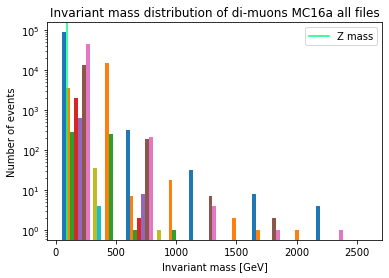

In [5]:
plt.figure()
plt.hist(np.array(masses)/1000, log = True, bins = 5) 
plt.xlabel("Invariant mass [GeV]")
plt.ylabel("Number of events")
plt.title("Invariant mass distribution of di-muons MC16a all files")
plt.axvline(x = 91, color = "springgreen", label = "Z mass") #Z mass
plt.legend()
plt.gcf().set_facecolor('white') #Make axes visible in VSCode dark theme
plt.show()

If we do not wish to separate data into separate datasets there is a workaround. Essentially we need to convert the jagged array (each element can have a variable sized length) into a fixed array with fillers we set to zero. From there we can flatten the array into a list of numbers (with many zeros) which is straightforward to plot. See the response by Jim Pavarski to the following StackOverflow post for more details https://stackoverflow.com/questions/69845177/convert-array-of-varying-sized-arrays-to-numpy-array . 

In [6]:
awkward_masses = ak.Array(masses)
max_length = np.max(ak.num(awkward_masses))

print(np.shape(ak.to_numpy(ak.pad_none(awkward_masses,max_length)))) #Matrix representation with filled in zeros

masses_flat = ak.to_numpy(ak.pad_none(awkward_masses,max_length)).flatten() #Flat representation

print(np.shape(masses_flat))

(13, 88385)
(1149005,)


/home/thillers/.conda/envs/testing/lib/python3.6/site-packages/numpy/ma/core.py:1184: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)


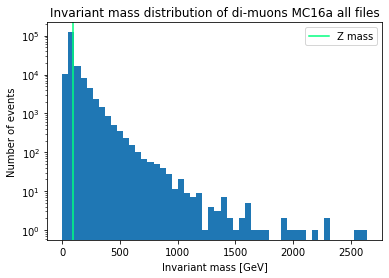

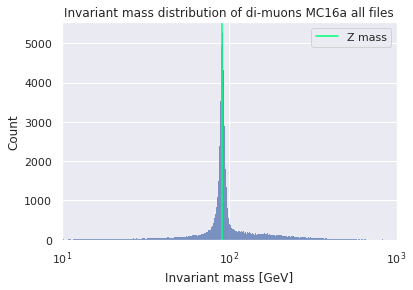

In [7]:
plt.figure()
plt.hist(masses_flat/1000, log = True, bins = 50)
plt.xlabel("Invariant mass [GeV]")
plt.ylabel("Number of events")
plt.title("Invariant mass distribution of di-muons MC16a all files")
plt.axvline(x = 91, color = "springgreen", label = "Z mass") #Z mass
plt.legend()
plt.gcf().set_facecolor('white') #Make axes visible in VSCode dark theme
plt.show()


plt.figure()
seaborn.set_theme()
seaborn.histplot(masses_flat/1000, log_scale= True)
plt.xlabel("Invariant mass [GeV]")
plt.xlim([10, 1000])
plt.title("Invariant mass distribution of di-muons MC16a all files")
plt.axvline(x = 91, color = "springgreen", label = "Z mass")
plt.legend()
plt.gcf().set_facecolor('white')
plt.show()
